# From classical to quantum repetition codes

## 1. The 3-bit classical correction

The most straight-forward way of implementing error-correction is to make three copies of the information (bit) that we wish to protect from  errors.
So $0$ gets mapped as $000$ (called a *logical* 0) and $1$ gets mapped as $111$ (*logical* 1). This assumes that the probability $p$ of a bit-flip is low enough that the required information can be recovered back to the single bit by simply looking at the majority. So if one obtains $101$ as the output bit, from the majority we see that $1$ is the intended bit of information. 

The critical requirement for this "majority vote" to work is that the probability of a bit flip $p$ remains low. We see why in the following demonstration.

### Example: Error rates with increasing probability

For a given "bit" of information, we first encode the corresponding logical bit by repeating it 3 times. Then we simulate an error by flipping the 3 bits with a probability $p$, and decode with a majority vote.

Given the probability of a bit flip $p$, the probability that two or more of the bits are flipped is given by:
$$ \underbrace{p\cdot p \cdot (1-p) + p\cdot (1-p)\cdot p + (1-p)\cdot p \cdot p}_{\text{probability of exactly two bit-flips}} + \underbrace{p^3}_{\text{probability of all three bits flipping}} $$

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np


In [2]:
def flip_bit(bit: str) -> str:
    return "1" if bit == "0" else "0"

def flip_bitstring(bitstring: str, probability: float) -> None:
    """Flip each bit of the given bitstring with the given probability."""
    flipped_bitstring: str = ""

    for bit in bitstring:
        if np.random.rand() < probability:
            flipped_bitstring += flip_bit(bit)
        else:
            flipped_bitstring += bit

    return flipped_bitstring

def majority_vote(bitstring: str) -> str:
    """Return the majority bit out of a given bitstring."""
    if len(bitstring)%2 == 0:
        print("Bitstring should have odd length for majority vote")
    ones_count: int = bitstring.count("1")
    zeros_count: int = bitstring.count("0")

    if ones_count > zeros_count:
        return "1"
    elif zeros_count > ones_count:
        return "0"
    return None

def error_sim_routine(bit: str, repeat_num: int = 3, probability: float = 0.3) -> str:
    """Run a full repetition error-correction routine."""
    repeated: str = bit * repeat_num
    after_error: str = flip_bitstring(repeated, probability)
    output_bit: str = majority_vote(after_error)

    return output_bit

def logical_error_rate(bit: str, repeat_num: int, probability: float, trials: int = 10_000) -> float:
    """Determine the logical error rate for a given probability, after a specified number of trials."""
    errors = 0
    for _ in range(trials):
        decoded: str = error_sim_routine(bit, repeat_num, probability)
        if decoded != bit:
            errors += 1
    return errors / trials

def logical_error_rate_theo(probability: float) -> float:
    """The logical error rate calculated analytically."""
    return 3*(probability**2) - 2*(probability**3)

In [3]:
p_vals: np.ndarray = np.linspace(0, 0.99, 100)
rates: list[float] = [logical_error_rate("0", 3, p) for p in p_vals]
rates_ideal: list[float] = [logical_error_rate_theo(p) for p in p_vals]
linear_curve: np.ndarray = p_vals.copy()

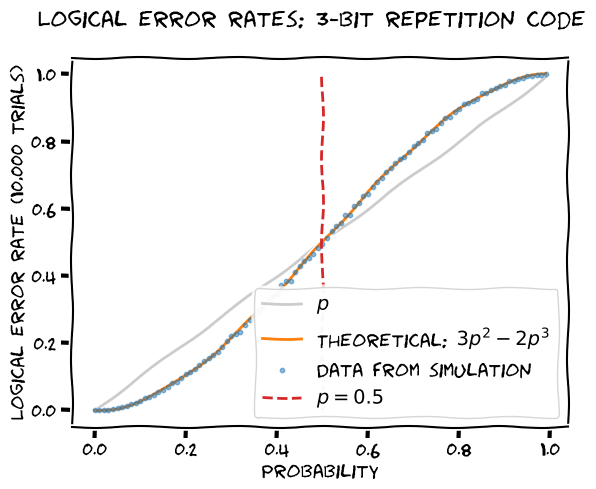

In [ ]:
cwd: Path = Path.cwd()
# %matplotlib inline
with plt.xkcd():
    plt.rcParams["font.family"] = "Humor Sans"   # force this font
    fig_test, ax_test = plt.subplots(1,1)

    ax_test.plot(p_vals, linear_curve, color="k", label=r"$p$", zorder=1, alpha=0.2)
    ax_test.plot(p_vals, rates_ideal, color="C1", label=r"Theoretical: $3p^2 - 2p^3$", zorder=1)
    ax_test.scatter(p_vals, rates, alpha=0.5, s=10, label=r"Data from simulation")
    ax_test.set_ylabel("Logical error rate (10,000 trials)")
    ax_test.set_xlabel("Probability")
    ax_test.vlines(x=0.5,ymin=0,ymax=1, linestyles='--', colors="C3", label=r"$p = 0.5$")

    ax_test.legend(loc="lower right")
    # fig_test.show()
    fig_test.suptitle("Logical error rates: 3-bit repetition code")
    fig_test.savefig(cwd.parent / "plots" / "classical_error_rates.png", dpi=300)

# fig_test.show();
# plt.show()

As we can see from the image below,the error rates (i.e., probability of getting the wrong bit out after majority vote) grows faster after around $p=0.5$.

<img src=plots/classical_error_rates.png width=500>

John Watrous from [his lecture notes](#references-in-this-notebook):
> For values of $p$ smaller than one-half, this results in a decrease in the probability that  the receiver ends up with the wrong bit. There will still be a chance of an error in  this case, but the code decreases the likelihood. (For values of $p$ greater than one-half,  on the other hand, the code actually increases the likelihood that the receiver gets  the wrong bit.)

## 2. The 3-qubit bit-flip correction

### 2.1. Repeating qubits

Encoding redundancy to qubits is a difficult task because the 'no-cloning theorem' forbids the duplication of a quantum state. Let's see how this can be worked around to get a quantum version of the 3-bit repetition code above:

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator   # requires qiskit-aer >= 0.15

In [6]:
def encode_bitflip(qc=None) -> QuantumCircuit:
    if not qc:
        qc = QuantumCircuit(3)
    # Assume qubit 0 holds the original |ψ⟩, qubits 1 and 2 start in |0⟩
    qc.cx(0, 1)  # copy state into qubit 1
    qc.cx(0, 2)  # copy state into qubit 2
    return qc

The circuit which implements the 3-qubit repetition ('qubit' repetition is perhaps a terrible choice to call it, read on to see why):

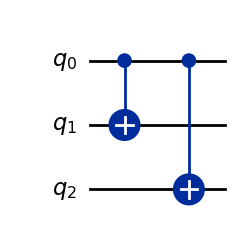

In [7]:
qc_encode = encode_bitflip()
qc_encode.draw("mpl")

Let's try to measure the output of the circuit to check if this indeed encodes the repetition code.

In [8]:
qc_encode.measure_all()
sim = AerSimulator()

# transpile the circuit for the chosen backend (qiskit aer)
tqc: QuantumCircuit = transpile(qc_encode, sim)

# create a job
job = sim.run(tqc, shots=10_000)

# define result object
result = job.result()

# result.get_counts returns a dict like {'010': 1}
counts: dict = result.get_counts()
print("Input: |000>, Output: ",counts)

Input: |000>, Output:  {'000': 10000}


How about with all "1" input?

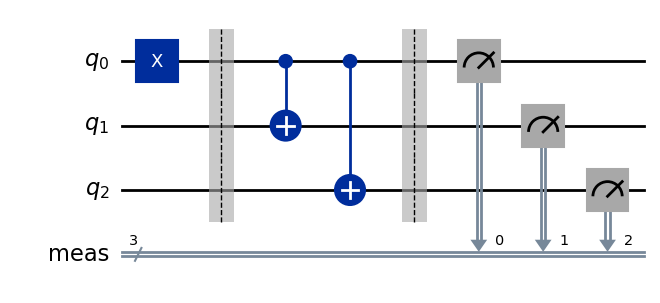

In [9]:
qc_encode_1: QuantumCircuit = QuantumCircuit(3)
qc_encode_1.x(0)
qc_encode_1.barrier()
qc_encode_1 = encode_bitflip(qc_encode_1)
qc_encode_1.measure_all()
qc_encode_1.draw("mpl")


In [10]:
sim = AerSimulator()
tqc: QuantumCircuit = transpile(qc_encode_1, sim)     # always transpile for the chosen backend
job = sim.run(tqc, shots=10_000)
result = job.result()
# result.get_counts returns a dict like {'010': 1}
counts = result.get_counts()
print("Input: |111>, Output: ",counts)

Input: |111>, Output:  {'111': 10000}


So we see that our circuit does indeed re-create the 3-bit repetition code.

How about a superposition state?

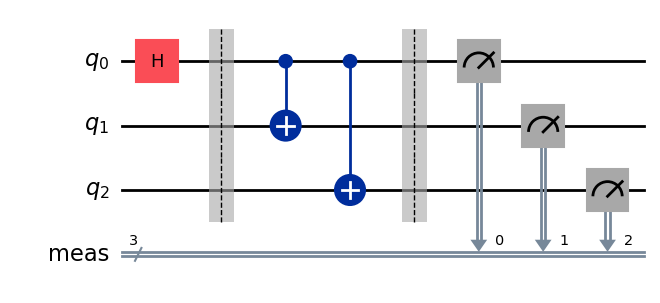

In [23]:
qc_encode_2: QuantumCircuit = QuantumCircuit(3)
qc_encode_2.h(0) # Hadamard here transforms |0> -> |+>
qc_encode_2.barrier()
qc_encode_2 = encode_bitflip(qc_encode_2)
qc_encode_2.measure_all()
qc_encode_2.draw("mpl")


In [24]:
sim = AerSimulator()
tqc: QuantumCircuit = transpile(qc_encode_2, sim)     # always transpile for the chosen backend
job = sim.run(tqc, shots=10_000)
result = job.result()
# result.get_counts returns a dict like {'010': 1}
counts = result.get_counts()
print("Input: |+>, Output: ",counts)

Input: |+>, Output:  {'000': 5013, '111': 4987}


An important fact to emphasize here is that, given a state 

$$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}, $$

we are NOT creating three copies of $\ket{\psi}$, i.e., $\ket{\psi} \longrightarrow \ket{\psi}\ket{\psi}\ket{\psi}$. Quantum Mechanics fundamentally forbids such an operation. What we are instead doing is,

$$ \alpha \ket{0} + \beta \ket{1} \rightarrow \alpha \ket{000} + \beta \ket{111} .$$

In other words, we are repeating the standard basis states. This also aligns with the result that we see in the result of the `qc_encode_2` circuit.

In [11]:
def apply_bitflip_noise(qc: QuantumCircuit, p: float) -> QuantumCircuit:
    noisy_qc: QuantumCircuit = qc.copy()
    for qubit in range(3):
        if np.random.rand() < p:
            noisy_qc.x(qubit)  # flip with probability p
    return noisy_qc

def add_measurements_in_place(qc: QuantumCircuit) -> None:
    print(qc)
    qc.measure([0, 1, 2], [0, 1, 2])   # map q0->c0, q1->c1, q2->c2

In [12]:
def run_one_trial(p: float, qc: QuantumCircuit = None) -> str:
    sim = AerSimulator()
    """Builds: encode → noise → measure, runs one shot, returns a 3-bit string like '010'."""
    qc_encoded: QuantumCircuit = encode_bitflip(qc)
    qc_noisy = apply_bitflip_noise(qc_encoded, p)
    qc_noisy.measure_all()

    tqc: QuantumCircuit = transpile(qc_noisy, sim)     # always transpile for the chosen backend
    job = sim.run(tqc, shots=1)
    result = job.result()
    # result.get_counts returns a dict like {'010': 1}
    counts = result.get_counts()
    (bitstring, _shots), = counts.items()    # unpack the single outcome
    # counts bit order matches classical bits [c0,c1,c2] => string like '010'
    return bitstring

In [13]:
majority_vote(run_one_trial(0.3))

'0'

### 2.2. How do we detect if there was an error?

In a simple classical information channel, detecting an error only meant checking the bit value to see if the input value was changed. This has no effect on the bit being transmitted. However in a quantum circuit, on measuring the state of a qubit, the original state $\psi$ collapses and the information is lost. This is the second significant (fundamental) challenge in quantum error correction.

# References in this notebook 
(outside of the [main ones](README.md#references))

1. [Understanding Quantum Information and Computation by John Watrous](https://arxiv.org/abs/2507.11536)